# LassoRegression for parameter selection

revisions
2021-10-31 - dgilroy - initial setup

In [1]:
# evaluate an lasso regression model on the dataset
from numpy import *
from matplotlib import *
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline

# importing the models
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

import itertools

### Load dataset trimed to 10000 observations per predictor

In [2]:
df = pd.read_csv('../finalDataSetForModelling.csv')

features = df.columns.tolist()

features.remove('CountryName')
features.remove('Life expectancy at birth, total (years)')

X=df[features]
y=df['Life expectancy at birth, total (years)']

###### Remove predictors that appear to be functions of the Y/Response

In [3]:
featuresToRemove = [
 'Death rate, crude (per 1,000 people)',
 'Mortality rate, adult, female (per 1,000 female adults)',
 'Mortality rate, under-5 (per 1,000)',
 'Population ages 65 and above (% of total)',
 'Survival to age 65, female (% of cohort)',
 'Survival to age 65, male (% of cohort)',
 'Year',
 'Mortality rate, adult, male (per 1,000 male adults)',
 'Mortality rate, infant (per 1,000 live births)',
 'Population, ages 15-64 (% of total)',
 'Age dependency ratio (% of working-age population)',
 'Age dependency ratio, old (% of working-age population)',
 'Age dependency ratio, young (% of working-age population)',
 'Population growth (annual %)',
 'Urban population growth (annual %)',
 'Population, ages 0-14 (% of total)',
 'Rural population growth (annual %)'
]

In [4]:
featuresToRemoveDueToMulticollinearity = [
    'Birth rate, crude (per 1,000 people)',
    'Rural population (% of total population)',
    'Population, female (% of total)',
    'Fertility rate, total (births per woman)',
    'Merchandise imports from high-income economies (% of total merchandise imports)',
    'Crop production index (2004-2006 = 100)',
    'Food production index (2004-2006 = 100)',
    'Livestock production index (2004-2006 = 100)',
    'Merchandise exports to high-income economies (% of total merchandise exports)'
]

In [5]:
X=X.drop(columns=featuresToRemove)
X=X.drop(columns=featuresToRemoveDueToMulticollinearity)
features = 10

#### Use lasso regression over a range of lambda's to find the predictors associated with a optimal fit for various alpha
This was done for the whole dataset. Second Lasso work was done via K-Folder Cross validation
After some initial review, lambda range 0.005-0.06 step 0.005 resulted in non-zero predictor count around ~10
Using the frequency of non-zero predictors across several lasso fits, the most frequcent non-zero predictors were used, and this resulted in 10 predictors.

In [6]:
lassoRange=arange(0.3,0.9,0.05)
allPredictors = []
X2 = StandardScaler().fit_transform(X)
for alphaValue in lassoRange:
    model = Lasso(alpha=alphaValue,max_iter=10000)
    model.fit(X2,y)
    numParameters = sum([int(x!=0) for x in model.coef_])
    print(alphaValue, numParameters)
    predictors = list(itertools.compress(list(X.columns),list([x!=0 for x in model.coef_])))
    allPredictors += predictors

allPredictorsAsSeries = pd.Series(allPredictors) 
predictorFrequency = dict(Counter(allPredictorsAsSeries))
predictorFrequencyDataframe = pd.DataFrame.from_dict(predictorFrequency, orient='index', columns=['frequency'])
predictorFrequencyDataframe.reset_index(inplace=True)
predictorFrequencyDataframe.columns=['predictor', 'frequency']

predictorTable = predictorFrequencyDataframe.sort_values('frequency',ascending=False)
top10predictors = predictorTable.head(features)['predictor'].tolist()
print(predictorTable)

top10predictors

0.3 11
0.35 11
0.39999999999999997 11
0.44999999999999996 10
0.49999999999999994 10
0.5499999999999999 9
0.5999999999999999 8
0.6499999999999999 7
0.7 7
0.7499999999999999 7
0.7999999999999998 7
0.8499999999999999 5
0.8999999999999999 5
                                            predictor  frequency
0   Adolescent fertility rate (births per 1,000 wo...         13
3                       Cereal yield (kg per hectare)         13
4                        GDP per capita (current US$)         13
5   Merchandise exports by the reporting economy, ...         13
10                      Urban population (% of total)         13
6   Merchandise imports by the reporting economy, ...         11
9   Population density (people per sq. km of land ...         11
2                   Arable land (hectares per person)          7
8                 Permanent cropland (% of land area)          6
7                        Merchandise trade (% of GDP)          5
1                  Agricultural land (% of land 

['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Cereal yield (kg per hectare)',
 'GDP per capita (current US$)',
 'Merchandise exports by the reporting economy, residual (% of total merchandise exports)',
 'Urban population (% of total)',
 'Merchandise imports by the reporting economy, residual (% of total merchandise imports)',
 'Population density (people per sq. km of land area)',
 'Arable land (hectares per person)',
 'Permanent cropland (% of land area)',
 'Merchandise trade (% of GDP)']

In [7]:
lassoPredictorsRanked = predictorFrequencyDataframe.sort_values('frequency',ascending=False)
lassoPredictorsRanked.to_csv("lassoPredictorsRanked.csv")

####  Do lasso via k-fold (5) cross validation over a range of lambda's to find the predictors associated with a optimal fit for various alpha
This was done for the whole dataset. Second Lasso work was done via K-Folder Cross validation
After some initial review, lambda range 0.005-0.06 step 0.005 resulted in non-zero predictor count around ~10
Using the frequency of non-zero predictors across several lasso fits, the most frequcent non-zero predictors were used, and this resulted in 10 predictors.

[fold 0] alpha: 0.35000, score: 0.72629
[fold 1] alpha: 0.75000, score: 0.77908
[fold 2] alpha: 0.35000, score: 0.74409
[fold 3] alpha: 0.75000, score: 0.71492
[fold 4] alpha: 0.50000, score: 0.70753


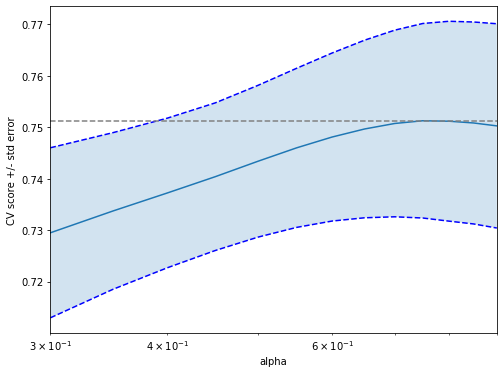

In [8]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = lassoRange

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X2, y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

# Use external cross-validation to see how much the automatically obtained
# alphas differ across different cross-validation folds.
lasso_cv = LassoCV(alphas=alphas, random_state=0, max_iter=10000)
k_fold = KFold(5)
allPredictors_cv = []
for k, (train, test) in enumerate(k_fold.split(X2, y)):
    lasso_cv.fit(X2[train], y[train])
    predictors_cv = list(itertools.compress(list(X.columns),list([x!=0 for x in lasso_cv.coef_])))
    allPredictors_cv += predictors_cv
    print(
        "[fold {0}] alpha: {1:.5f}, score: {2:.5f}".format(
            k, lasso_cv.alpha_, lasso_cv.score(X2[test], y[test])
        )
    )

plt.savefig("top10predictorsLasso_cv_5_fold_.3to.9by.05.jpg")
plt.show()

In [9]:
allPredictorsAsSeries_cv = pd.Series(allPredictors_cv) 
predictorFrequency_cv = dict(Counter(allPredictorsAsSeries_cv))
predictorFrequencyDataframe_cv = pd.DataFrame.from_dict(predictorFrequency_cv, orient='index', columns=['frequency'])
predictorFrequencyDataframe_cv.reset_index(inplace=True)
predictorFrequencyDataframe_cv.columns=['predictor', 'frequency']
predictorFrequencyTable=predictorFrequencyDataframe_cv.sort_values('frequency',ascending=False)
top10predictorsLasso_cv = predictorFrequencyTable.head(features)['predictor'].tolist()
predictorFrequencyTable.to_csv("LassoPredictorTableFrequencyDistribution.csv")
pd.DataFrame(top10predictorsLasso_cv).to_csv("top10predictorsLasso_cv.csv")
predictorFrequencyDataframe_cv.sort_values('frequency',ascending=False)

,predictor,frequency
0,"Adolescent fertility rate (births per 1,000 wo...",5
5,Cereal yield (kg per hectare),5
9,Urban population (% of total),5
6,GDP per capita (current US$),4
7,"Merchandise exports by the reporting economy, ...",4
8,Permanent cropland (% of land area),4
10,"Merchandise imports by the reporting economy, ...",4
11,Population density (people per sq. km of land ...,4
1,Agricultural land (% of land area),2
3,Arable land (hectares per person),2


In [10]:
top10predictorsLasso_cv

['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Cereal yield (kg per hectare)',
 'Urban population (% of total)',
 'GDP per capita (current US$)',
 'Merchandise exports by the reporting economy, residual (% of total merchandise exports)',
 'Permanent cropland (% of land area)',
 'Merchandise imports by the reporting economy, residual (% of total merchandise imports)',
 'Population density (people per sq. km of land area)',
 'Agricultural land (% of land area)',
 'Arable land (hectares per person)']

### Redo feature selection by way for Sequential Forward Selection
http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [11]:
def GetFeatures(k_features, X, y, verbose):
    # calling the linear regression model
    lreg = LinearRegression()
    sfs1 = SFS(lreg, k_features=k_features, forward=True, verbose=verbose, scoring='neg_mean_squared_error')

    sfs1 = sfs1.fit(X, y)

    feat_names = list(sfs1.k_feature_idx_)
    return feat_names

#### This does a fit to all the data, not leveraging any crossvalidation to determine the features selected

In [12]:
features_selected = GetFeatures(features, X, y, False)
# property_asel = [X.columns[i] for i in sfs_predicorIdexes]
# property_asel

In [13]:
sfs_predicorIdexes1 = list(map(lambda x : x, features_selected))
property_asel_1 = [X.columns[i] for i in sfs_predicorIdexes1]
property_asel_1

['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Arable land (hectares per person)',
 'CO2 emissions from solid fuel consumption (kt)',
 'GDP per capita (current US$)',
 'Merchandise exports by the reporting economy, residual (% of total merchandise exports)',
 'Merchandise trade (% of GDP)',
 'Number of under-five deaths',
 'Permanent cropland (% of land area)',
 'Rural population',
 'Urban population (% of total)']

In [14]:
pd.DataFrame(property_asel_1).to_csv("ForwardSelection1.csv")

#### This use cross validation with k-fold of 10 to determine the features selected

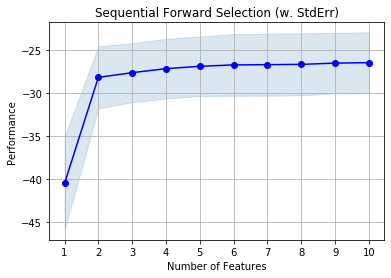

In [15]:
lr = LinearRegression()

sfs = SFS(lr, 
          k_features=features, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [16]:
#print('Selected features:', sfs.k_feature_idx_)
type(list(sfs.k_feature_idx_))
sfs_predicorIdexes = list(map(lambda x : x, list(sfs.k_feature_idx_)))
property_asel = [X.columns[i] for i in sfs_predicorIdexes]
property_asel

['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Agricultural land (sq. km)',
 'Arable land (hectares per person)',
 'CO2 emissions from solid fuel consumption (kt)',
 'GDP per capita (current US$)',
 'Merchandise exports by the reporting economy, residual (% of total merchandise exports)',
 'Number of infant deaths',
 'Number of under-five deaths',
 'Permanent cropland (% of land area)',
 'Urban population (% of total)']

#### This another way to use cross validation with k-fold of 5 to determine the features selected

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.33, random_state=1)

best combination (ACC: -25.162): (0, 3, 4, 12, 16, 21, 25, 28, 29, 34)



['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Arable land (% of land area)',
 'Arable land (hectares per person)',
 'CO2 emissions from solid fuel consumption (kt)',
 'GDP per capita (current US$)',
 'Merchandise exports by the reporting economy, residual (% of total merchandise exports)',
 'Merchandise trade (% of GDP)',
 'Permanent cropland (% of land area)',
 'Population density (people per sq. km of land area)',
 'Urban population (% of total)']

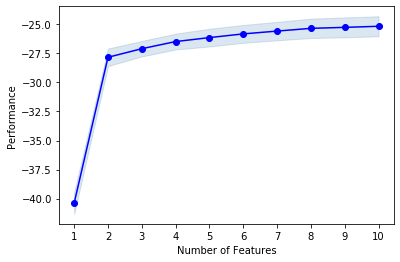

In [18]:
lr = LinearRegression()

sfs1 = SFS(estimator=lr, 
           k_features=features,
           forward=True, 
           floating=False, 
           scoring='neg_mean_squared_error',
           cv=5)

pipe = make_pipeline(StandardScaler(), sfs1)

pipe.fit(X_train, y_train)

print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
#print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_err');

sfs_predicorIdexes_2 = list(map(lambda x : x, list(sfs1.k_feature_idx_)))

property_asel_2 = [X.columns[i] for i in sfs_predicorIdexes_2]
pd.DataFrame(property_asel_2).to_csv("ForwardSelectionVia5FoldCV.csv")
property_asel_2

#### And yet another way to use cross validation with k-fold of 5 to determine the features selected

In [19]:

groups = np.arange(len(y)) // 10
print('groups: {}'.format(groups))

from sklearn.model_selection import GroupKFold
cv_gen = GroupKFold(5).split(X, y, groups)
cv_gen

cv = list(cv_gen)

sfs3 = SFS(estimator=lr, 
          k_features=features,
          scoring='neg_mean_squared_error',
          cv=cv)

sfs3.fit(X, y)

print('best combination (ACC: %.3f): %s\n' % (sfs3.k_score_, sfs3.k_feature_idx_))

sfs_predicorIdexes_3 = list(map(lambda x : x + 1, list(sfs3.k_feature_idx_)))

property_asel_3 = [X.columns[i] for i in sfs_predicorIdexes_2]
property_asel_3

groups: [  0   0   0 ... 625 625 625]
best combination (ACC: -25.217): (0, 1, 3, 4, 12, 16, 21, 28, 29, 34)



['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Arable land (% of land area)',
 'Arable land (hectares per person)',
 'CO2 emissions from solid fuel consumption (kt)',
 'GDP per capita (current US$)',
 'Merchandise exports by the reporting economy, residual (% of total merchandise exports)',
 'Merchandise trade (% of GDP)',
 'Permanent cropland (% of land area)',
 'Population density (people per sq. km of land area)',
 'Urban population (% of total)']

### Create a new dataset for the possible features to use for modelling
This combines the features found via lasso and forward selection to use in our knn and linear regression models

In [20]:
fowardSelectionFeatures=property_asel_3
lassoSelectionFeatures=top10predictorsLasso_cv

selectedFeatures = lassoSelectionFeatures + list(set(fowardSelectionFeatures) - set(lassoSelectionFeatures))
selectedFeatures

finalColumns = list(selectedFeatures)
finalColumns.append('Life expectancy at birth, total (years)')
finalColumns.append('Year')
finalColumns.append('CountryName')

featureSelectedDataset = df[finalColumns]
featureSelectedDataset.reset_index()

meanByYear = featureSelectedDataset[['Year','Life expectancy at birth, total (years)']].groupby('Year').mean().reset_index()
meanOverall = featureSelectedDataset[['Life expectancy at birth, total (years)']].mean()

featureSelectedDataset['MeanLifeExpetancyOverall'] = meanOverall[0]

meanByYear= meanByYear.rename(columns={'Life expectancy at birth, total (years)':'MeanLifeExpetancyForYear'})

featureSelectedDataset = pd.merge(left=featureSelectedDataset,right=meanByYear)

featureSelectedDataset['AboveAverageLifeExpectancyOverall'] = featureSelectedDataset['Life expectancy at birth, total (years)']>featureSelectedDataset['MeanLifeExpetancyOverall']

featureSelectedDataset['AboveAverageLifeExpectancyByYear'] = featureSelectedDataset['Life expectancy at birth, total (years)']>featureSelectedDataset['MeanLifeExpetancyForYear']

featureSelectedDataset.to_csv("LassoForwardSelectionDataSetForModelling.csv", index=False)

C:\Users\danxg\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
